# Computatation of Signal-to-Noise Ratio
refers to [Rupprecht et al., 2021](https://www.nature.com/articles/s41593-021-00895-5)
and [blog](https://gcamp6f.com/2021/10/04/large-scale-calcium-imaging-noise-levels/)

In [1]:
from mylib.statistic_test import *

code_id = '0353 - SNR and SFER'
loc = os.path.join(figpath, code_id)
mkdir(loc)

pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0353 - SNR and SFER is already existed!


In [2]:
with open(f_CellReg_modi['Trace File'][12], 'rb') as f:
    trace_mdays = pickle.load(f)

fps = 20 # Frame per second

def get_noise_level(dFF: np.ndarray, fps: float = fps):
    thre = np.percentile(dFF, 97.5, axis=1)
    noise = np.zeros(dFF.shape[0]) * np.nan
    for i in range(dFF.shape[0]):
        noise[i] = np.std(dFF[i, dFF[i, :] < thre[i]])
    return noise


def process_fieldcenter_nan(field_centers):
    idx0 = np.where(
        (np.isnan(field_centers[0, :])) &
        (np.isnan(field_centers[1, :]) == False)
    )[0]
    field_centers[0, idx0] = field_centers[1, idx0]

    idx1 = np.where(
        (np.isnan(field_centers[1, :])) &
        (np.isnan(field_centers[0, :]) == False)
    )[0]
    field_centers[1, idx1] = field_centers[0, idx1]
    
    return field_centers

def evolution_event_vs_dFF(
    i: int,
    f: pd.DataFrame = f_CellReg_modi,
    dirs: str = 'cis',
):
    cellreg_dir = f['cellreg_folder'][i]
    mouse = int(f['MiceID'][i])
    stage = f['Stage'][i]
    session = int(f['session'][i])
    maze_type = int(f['maze_type'][i])
    behavior_paradigm = f['paradigm'][i]
    
    if behavior_paradigm == 'CrossMaze':
        fdata = f1
    elif behavior_paradigm == 'ReverseMaze':
        fdata = f3
    elif behavior_paradigm == 'HairpinMaze':
        fdata = f4
    else:
        raise ValueError(f"Paradigm {behavior_paradigm} is not supported.")

    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]

    with open(f['Trace File'][i], 'rb') as handle:
        trace_mdays = pickle.load(handle)

    traces = []
    print(f"  Load Traces: ", end='')
    for j in tqdm(file_indices):
        with open(fdata['Trace File'][j], 'rb') as handle:
            trace = pickle.load(handle)

        trace['Noise'] = get_noise_level(trace['RawTraces'], fps=fps)
        traces.append(trace)
        
    index_map = GetMultidayIndexmap(
        mouse,
        stage=stage,
        session=session,
        i = i,
        occu_num=2
    )
    index_map[np.where((np.isnan(index_map))|(index_map < 0))] = 0
    index_map = index_map.astype(np.int64)
        
    try:
        field_reg = trace_mdays['field_reg']
        field_info = trace_mdays['field_info']
    except:
        field_reg = trace_mdays[dirs]['field_reg']
        field_info = trace_mdays[dirs]['field_info']
        
    field_info_adv = np.zeros((field_info.shape[0], field_info.shape[1], 4)) * np.nan

    # field to cell mapping
    ftc_mapping = field_info[:, :, 0]
        
    res = {
        "Session": [],
        "Event": [],
        "Max dF/F": [],
        "Noise": [],
        "SNR": [],
        "Rate": [],
        "Pre or Post": [],
    }
    print("  Get Property Changes with Events: ", end='')
    for s in tqdm(range(file_indices.shape[0]-1)):
        field_idx = np.where(
            (ftc_mapping[s, :] > 0) &
            (ftc_mapping[s+1, :] > 0)
        )[0]
        ftc_s = ftc_mapping[:, field_idx][s:s+2, :].astype(np.int64)
        reg_s = field_reg[:, field_idx][s:s+2, :].astype(np.int64)
        # Field Retention
        ret_idx = np.where(
            (reg_s[0, :] == 1) &
            (reg_s[1, :] == 1)
        )[0]
        max_dFF_changes = np.vstack([
            np.max(traces[s]['RawTraces'][ftc_s[0, ret_idx]-1, :], axis=1),
            np.max(traces[s+1]['RawTraces'][ftc_s[1, ret_idx]-1, :], axis=1)
        ])
        noises = np.vstack([
            traces[s]['Noise'][ftc_s[0, ret_idx]-1],
            traces[s+1]['Noise'][ftc_s[1, ret_idx]-1]
        ])
        snr = max_dFF_changes / noises
        field_center_ret = np.vstack([
            field_info[s, field_idx[ret_idx], 2],
            field_info[s+1, field_idx[ret_idx], 2],
        ])
        field_center_ret = process_fieldcenter_nan(field_center_ret)-1
        
        if np.where(np.isnan(field_center_ret))[0].shape[0] > 0:
            raise ValueError("NaN in field center")
        else:
            field_center_ret = field_center_ret.astype(np.int64)
            try:
                rates = np.vstack([
                    traces[s]['smooth_map_all'][(ftc_s[0, ret_idx]-1), field_center_ret[0, :]],
                    traces[s+1]['smooth_map_all'][(ftc_s[1, ret_idx]-1), field_center_ret[1, :]]
                ])
            except:
                rates = np.vstack([
                    traces[s][dirs]['smooth_map_all'][(ftc_s[0, ret_idx]-1), field_center_ret[0, :]],
                    traces[s+1][dirs]['smooth_map_all'][(ftc_s[1, ret_idx]-1), field_center_ret[1, :]]
                ])
                
        field_info_adv[s:s+2, field_idx[ret_idx], 0] = max_dFF_changes
        field_info_adv[s:s+2, field_idx[ret_idx], 1] = noises
        field_info_adv[s:s+2, field_idx[ret_idx], 2] = snr
        field_info_adv[s:s+2, field_idx[ret_idx], 3] = rates
        res['Session'].append(np.array([s, s]))
        res['Event'].append(np.repeat('Retention', 2))
        res['Max dF/F'].append(np.nanmean(max_dFF_changes, axis=1))
        res['Noise'].append(np.nanmean(noises, axis=1))
        res['SNR'].append(np.nanmean(max_dFF_changes / noises, axis=1))
        res['Rate'].append(np.nanmean(rates, axis=1))
        res['Pre or Post'].append(np.array(['Pre', 'Post']))
        

        # Field Disappearance
        dis_idx = np.where(
            (reg_s[0, :] == 1) &
            (reg_s[1, :] == 0)
        )[0]
        max_dFF_changes_ = np.vstack([
            np.max(traces[s]['RawTraces'][ftc_s[0, dis_idx]-1, :], axis=1),
            np.max(traces[s+1]['RawTraces'][ftc_s[1, dis_idx]-1, :], axis=1)
        ])
        noises = np.vstack([
            traces[s]['Noise'][ftc_s[0, dis_idx]-1],
            traces[s+1]['Noise'][ftc_s[1, dis_idx]-1]
        ])
        snr = max_dFF_changes_ / noises
        field_center_dis = np.vstack([
            field_info[s, field_idx[dis_idx], 2],
            field_info[s+1, field_idx[dis_idx], 2],
        ])
        field_center_dis = process_fieldcenter_nan(field_center_dis)-1
        if np.where(np.isnan(field_center_dis))[0].shape[0] > 0:
            raise ValueError("NaN in field center")
        else:
            field_center_dis = field_center_dis.astype(np.int64)
            try:
                rates = np.vstack([
                    traces[s]['smooth_map_all'][(ftc_s[0, dis_idx]-1), field_center_dis[0, :]],
                    traces[s+1]['smooth_map_all'][(ftc_s[1, dis_idx]-1), field_center_dis[1, :]]
                ])
            except:
                rates = np.vstack([
                    traces[s][dirs]['smooth_map_all'][(ftc_s[0, dis_idx]-1), field_center_dis[0, :]],
                    traces[s+1][dirs]['smooth_map_all'][(ftc_s[1, dis_idx]-1), field_center_dis[1, :]]
                ])
        field_info_adv[s:s+2, field_idx[dis_idx], 0] = max_dFF_changes_
        field_info_adv[s:s+2, field_idx[dis_idx], 1] = noises
        field_info_adv[s:s+2, field_idx[dis_idx], 2] = snr
        field_info_adv[s:s+2, field_idx[dis_idx], 3] = rates
        
        res['Session'].append(np.array([s, s]))
        res['Event'].append(np.repeat('Disappearance', 2))
        res['Max dF/F'].append(np.nanmean(max_dFF_changes_, axis=1))
        res['Noise'].append(np.nanmean(noises, axis=1))
        res['SNR'].append(np.nanmean(max_dFF_changes_ / noises, axis=1))
        res['Rate'].append(np.nanmean(rates, axis=1))
        res['Pre or Post'].append(np.array(['Pre', 'Post']))

        # Field Emergence
        eme_idx = np.where(
            (reg_s[0, :] == 0) &
            (reg_s[1, :] == 1)
        )[0]
        max_dFF_changes__ = np.vstack([
            np.max(traces[s]['RawTraces'][ftc_s[0, eme_idx]-1, :], axis=1), 
            np.max(traces[s+1]['RawTraces'][ftc_s[1, eme_idx]-1, :], axis=1)
        ])
        noises = np.vstack([
            traces[s]['Noise'][ftc_s[0, eme_idx]-1],
            traces[s+1]['Noise'][ftc_s[1, eme_idx]-1]
        ])
        snr = max_dFF_changes__ / noises
        field_center_eme = np.vstack([
            field_info[s, field_idx[eme_idx], 2],
            field_info[s+1, field_idx[eme_idx], 2],
        ])
        field_center_eme = process_fieldcenter_nan(field_center_eme)-1
        if np.where(np.isnan(field_center_eme))[0].shape[0] > 0:
            raise ValueError("NaN in field center")
        else:
            field_center_eme = field_center_eme.astype(np.int64)
            try:
                rates = np.vstack([
                    traces[s]['smooth_map_all'][(ftc_s[0, eme_idx]-1), field_center_eme[0, :]],
                    traces[s+1]['smooth_map_all'][(ftc_s[1, eme_idx]-1), field_center_eme[1, :]]
                ])
            except:
                rates = np.vstack([
                    traces[s][dirs]['smooth_map_all'][(ftc_s[0, eme_idx]-1), field_center_eme[0, :]],
                    traces[s+1][dirs]['smooth_map_all'][(ftc_s[1, eme_idx]-1), field_center_eme[1, :]]
                ])
        field_info_adv[s:s+2, field_idx[eme_idx], 0] = max_dFF_changes__
        field_info_adv[s:s+2, field_idx[eme_idx], 1] = noises
        field_info_adv[s:s+2, field_idx[eme_idx], 2] = snr
        field_info_adv[s:s+2, field_idx[eme_idx], 3] = rates

        res['Session'].append(np.array([s, s]))
        res['Event'].append(np.repeat('Emergence', 2))
        res['Max dF/F'].append(np.nanmean(max_dFF_changes__, axis=1))
        res['Noise'].append(np.nanmean(noises, axis=1))
        res['SNR'].append(np.nanmean(max_dFF_changes__ / noises, axis=1))
        res['Rate'].append(np.nanmean(rates, axis=1))
        res['Pre or Post'].append(np.array(['Pre', 'Post']))
        
    if 'field_reg' in trace_mdays.keys():
        trace_mdays['field_info_adv'] = field_info_adv
    else:
        trace_mdays[dirs]['field_info_adv'] = field_info_adv

    with open(f['Trace File'][i], 'wb') as handle:
        pickle.dump(trace_mdays, handle)

    for k in res.keys():
        res[k] = np.concatenate(res[k])

    return res

if exists(join(figdata, f"{code_id}.pkl")) == False:
    ChangeWithEvent = {
        "MiceID": [],
        "Paradigm": [],
        "Session": [],
        "Event": [],
        "Max dF/F": [],
        "Noise": [],
        "SNR": [],
        "Rate": [],
        "Pre or Post": []
    }
    
    for i in range(f_CellReg_modi.shape[0]):
        if f_CellReg_modi['Type'][i] != 'Real':
            continue
        
        mouse = int(f_CellReg_modi['MiceID'][i])
        print(f"Mouse {mouse} ",end='')
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            paradm = "MA" if f_CellReg_modi['maze_type'][i] == 1 else "MB"
            print(paradm)
            res = evolution_event_vs_dFF(i)
            for k in ChangeWithEvent.keys():
                if k == "MiceID":
                    ChangeWithEvent[k].append(np.repeat(mouse, res['Session'].shape[0]))
                elif k == "Paradigm":
                    ChangeWithEvent[k].append(np.repeat(paradm, res['Session'].shape[0]))
                else:
                    ChangeWithEvent[k].append(res[k])
                    
        elif f_CellReg_modi['paradigm'][i] == 'ReverseMaze':
            for dirs, paradm in zip(['cis', 'trs'], ['MAf', 'MAb']):
                print(paradm)
                res = evolution_event_vs_dFF(i, dirs=dirs)
                for k in ChangeWithEvent.keys():
                    if k == "MiceID":
                        ChangeWithEvent[k].append(np.repeat(mouse, res['Session'].shape[0]))
                    elif k == "Paradigm":
                        ChangeWithEvent[k].append(np.repeat(paradm, res['Session'].shape[0]))
                    else:
                        ChangeWithEvent[k].append(res[k])
        elif f_CellReg_modi['paradigm'][i] == 'HairpinMaze':
            for dirs, paradm in zip(['cis', 'trs'], ['HPf', 'HPb']):
                print(paradm)
                res = evolution_event_vs_dFF(i, dirs=dirs)
                for k in ChangeWithEvent.keys():
                    if k == "MiceID":
                        ChangeWithEvent[k].append(np.repeat(mouse, res['Session'].shape[0]))
                    elif k == "Paradigm":
                        ChangeWithEvent[k].append(np.repeat(paradm, res['Session'].shape[0]))
                    else:
                        ChangeWithEvent[k].append(res[k])
                        
    for k in ChangeWithEvent.keys():
        ChangeWithEvent[k] = np.concatenate(ChangeWithEvent[k])
        
    ChangeWithEventD = pd.DataFrame(ChangeWithEvent)
    with open(join(figdata, f"{code_id}.pkl"), 'wb') as f:
        pickle.dump(ChangeWithEvent, f)
        
    ChangeWithEventD.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
    print(len(ChangeWithEventD))
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as f:
        ChangeWithEvent = pickle.load(f)

if exists(join(figdata, f"{code_id} [Session-Average].pkl")) == False:
    AvgChange = {
        "MiceID": [],
        "Paradigm": [],
        "Event": [],
        "Max dF/F": [],
        "Noise": [],
        "SNR": [],
        "Rate": [],
        "Pre or Post": []
    }
    for paradm in np.unique(ChangeWithEvent['Paradigm']):
        for mouse in np.unique(ChangeWithEvent['MiceID'][ChangeWithEvent['Paradigm'] == paradm]):
            for event in np.unique(ChangeWithEvent['Event'][(ChangeWithEvent['MiceID'] == mouse) & (ChangeWithEvent['Paradigm'] == paradm)]):
                for pp in ['Pre', 'Post']:
                    idx = np.where(
                        (ChangeWithEvent['MiceID'] == mouse) &
                        (ChangeWithEvent['Paradigm'] == paradm) &
                        (ChangeWithEvent['Event'] == event) &
                        (ChangeWithEvent['Pre or Post'] == pp)
                    )[0]
                    if idx.shape[0] == 0:
                        continue
                    AvgChange['MiceID'].append(mouse)
                    AvgChange['Paradigm'].append(paradm)
                    AvgChange['Event'].append(event)
                    AvgChange['Pre or Post'].append(pp)
                    AvgChange['Max dF/F'].append(np.nanmean(ChangeWithEvent['Max dF/F'][idx]))
                    AvgChange['Noise'].append(np.nanmean(ChangeWithEvent['Noise'][idx]))
                    AvgChange['SNR'].append(np.nanmean(ChangeWithEvent['SNR'][idx]))
                    AvgChange['Rate'].append(np.nanmean(ChangeWithEvent['Rate'][idx]))
                    
    for k in AvgChange.keys():
        AvgChange[k] = np.array(AvgChange[k])
        
    AvgChangeD = pd.DataFrame(AvgChange)
    with open(join(figdata, f"{code_id} [Session-Average].pkl"), 'wb') as handle:
        pickle.dump(AvgChange, handle)

    AvgChangeD.to_excel(join(figdata, f"{code_id} [Session-Average].xlsx"), index=False)
    print(len(AvgChangeD))
else:
    with open(join(figdata, f"{code_id} [Session-Average].pkl"), 'rb') as handle:
        AvgChange = pickle.load(handle)
        
event_set = ['Retention', 'Disappearance', 'Emergence']
paradm_set = ['MA', 'MB', 'MAf', 'MAb', 'HPf', 'HPb']

# Max dF/F

Retention MA: TtestResult(statistic=1.727321336771886, pvalue=0.1446901367725174, df=5)
Retention MB: TtestResult(statistic=1.8505195002858768, pvalue=0.12346623790975056, df=5)
Retention MAf: TtestResult(statistic=-0.7735464706988845, pvalue=0.4955617039060651, df=3)
Retention MAb: TtestResult(statistic=-0.3250979895330216, pvalue=0.7664593931064589, df=3)
Retention HPf: TtestResult(statistic=-0.022724529608719683, pvalue=0.9832969969569655, df=3)
Retention HPb: TtestResult(statistic=-0.2705812167666297, pvalue=0.8042610356050828, df=3)


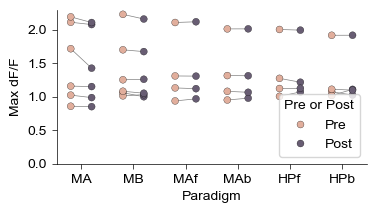

Disappearance MA: TtestResult(statistic=0.2546392126290363, pvalue=0.8091431698330352, df=5)
Disappearance MB: TtestResult(statistic=-2.0192710550281125, pvalue=0.09946272808472531, df=5)
Disappearance MAf: TtestResult(statistic=-4.790766984411899, pvalue=0.017298502775656564, df=3)
Disappearance MAb: TtestResult(statistic=-6.842832159046347, pvalue=0.006387658993462021, df=3)
Disappearance HPf: TtestResult(statistic=-3.8267935291386834, pvalue=0.03142851843387192, df=3)
Disappearance HPb: TtestResult(statistic=-3.194329980087956, pvalue=0.04954642425451846, df=3)


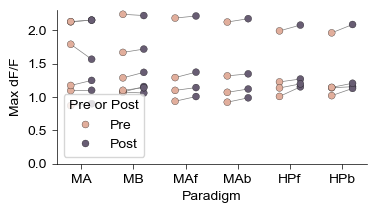

Emergence MA: TtestResult(statistic=2.2349406291089484, pvalue=0.07569388661907185, df=5)
Emergence MB: TtestResult(statistic=5.249114939361392, pvalue=0.003328658073189813, df=5)
Emergence MAf: TtestResult(statistic=1.943468180577233, pvalue=0.14721115948407051, df=3)
Emergence MAb: TtestResult(statistic=2.1171552673370373, pvalue=0.12451810191502939, df=3)
Emergence HPf: TtestResult(statistic=2.078718364793669, pvalue=0.12916065530165474, df=3)
Emergence HPb: TtestResult(statistic=1.692656921001066, pvalue=0.18909695374705235, df=3)


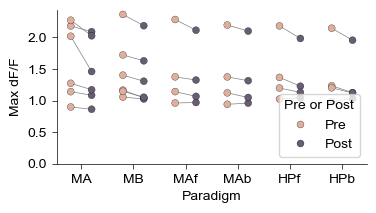

MA
  Mean: 1.5367477436709098, STD: 0.7342534197828021, Max: 9.568552815697462, Min: 0.6625845342563129, Median: 1.2936202700102704, df: 293
  Mean: 1.551945438926725, STD: 0.8404276796623171, Max: 12.019274076158652, Min: 0.6567657521520769, Median: 1.3021239630497914, df: 293
  Mean: 1.4809502559919918, STD: 0.6744577848441651, Max: 7.581592151075838, Min: 0.6574408888701405, Median: 1.1965166329312615, df: 293
F_onewayResult(statistic=0.7224146487128789, pvalue=0.48586640725600294)

MB
  Mean: 1.425405541013368, STD: 0.4852147309755448, Max: 3.0607136254370664, Min: 0.8054209313736728, Median: 1.2922701184859293, df: 143
  Mean: 1.4251564908059726, STD: 0.4985596323304363, Max: 2.9573756487143417, Min: 0.7885564728768604, Median: 1.2995881377726701, df: 143
  Mean: 1.3739624612045123, STD: 0.48599061416326605, Max: 3.0394066021623427, Min: 0.7771206753466215, Median: 1.2082749003364348, df: 143
F_onewayResult(statistic=0.5229381527132451, pvalue=0.5931536893827278)

MAf
  Mean: 1.33

In [5]:
for event in event_set:
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    SubData = SubDict(AvgChange, AvgChange.keys(), np.where(AvgChange['Event'] == event)[0])
    """
    sns.barplot(
        x='Paradigm',
        y='Max dF/F',
        hue='Pre or Post',
        data=SubData,
        capsize=0.4,
        err_kws={'linewidth':.5, 'color':'black'},
        palette=['#E1AE9C', '#685d73'],
        ax=ax,
        zorder=2,
        width=0.8,
        gap=0.3
    )"""
    sns.stripplot(
        x='Paradigm',
        y='Max dF/F',
        hue='Pre or Post',
        data=SubData,
        order=paradm_set,
        palette=['#E1AE9C', '#685d73'],
        dodge=True,
        edgecolor='k',
        linewidth=0.2,
        jitter=0,
        size=5,
        ax=ax,
        zorder=1,
    )
    for i, paradm in enumerate(paradm_set):
        idx_pre = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Pre')
        )[0]
        idx_post = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Post')
        )[0]
        print(f"{event} {paradm}: {ttest_rel(SubData['Max dF/F'][idx_pre], SubData['Max dF/F'][idx_post])}")
        for j in range(idx_pre.shape[0]):
            ax.plot(
                [i-0.2, i+0.2],
                [SubData['Max dF/F'][idx_pre[j]], SubData['Max dF/F'][idx_post[j]]],
                color='gray',
                linewidth=0.5,
                zorder=0
            )
        
    ax.set_ylim(0, ax.get_ylim()[1])
    plt.savefig(join(loc, f"Max dF-F Change [{event}].png"), dpi=600)
    plt.savefig(join(loc, f"Max dF-F Change [{event}].svg"))
    plt.show()

for paradm in paradm_set:
    idx_ret = np.where(
        (ChangeWithEvent['Event'] == 'Retention') &
        (ChangeWithEvent['Paradigm'] == paradm)
    )[0]
    idx_dis = np.where(
        (ChangeWithEvent['Event'] == 'Disappearance') &
        (ChangeWithEvent['Paradigm'] == paradm)
    )[0]
    idx_eme = np.where(
        (ChangeWithEvent['Event'] == 'Emergence') &
        (ChangeWithEvent['Paradigm'] == paradm)
    )[0]
    print(paradm)
    print_estimator(ChangeWithEvent['Max dF/F'][idx_dis])
    print_estimator(ChangeWithEvent['Max dF/F'][idx_eme])
    print_estimator(ChangeWithEvent['Max dF/F'][idx_ret])
    print(f"{f_oneway(ChangeWithEvent['Max dF/F'][idx_ret], ChangeWithEvent['Max dF/F'][idx_dis], ChangeWithEvent['Max dF/F'][idx_eme])}")
    print()

# Noise Level

Retention MA: TtestResult(statistic=1.678255695083641, pvalue=0.15413767074767615, df=5)
Retention MB: TtestResult(statistic=-0.8850508700365607, pvalue=0.41665519856199656, df=5)
Retention MAf: TtestResult(statistic=-2.3537278586029116, pvalue=0.09996693513948661, df=3)
Retention MAb: TtestResult(statistic=-3.690262411480182, pvalue=0.0345102575663692, df=3)
Retention HPf: TtestResult(statistic=-0.8335983054534141, pvalue=0.465669764748459, df=3)
Retention HPb: TtestResult(statistic=-1.0991486857872954, pvalue=0.35200110983956767, df=3)


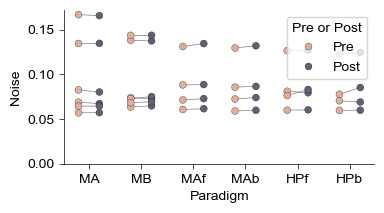

Disappearance MA: TtestResult(statistic=-0.13156191802326747, pvalue=0.9004607688577054, df=5)
Disappearance MB: TtestResult(statistic=-0.9545145718020375, pvalue=0.3836585820141514, df=5)
Disappearance MAf: TtestResult(statistic=-1.2194754938237953, pvalue=0.3097945306639588, df=3)
Disappearance MAb: TtestResult(statistic=-1.0612106605874798, pvalue=0.36645819992599277, df=3)
Disappearance HPf: TtestResult(statistic=-0.6225825339861556, pvalue=0.5776745552352432, df=3)
Disappearance HPb: TtestResult(statistic=-1.1091191728906868, pvalue=0.34829543273408936, df=3)


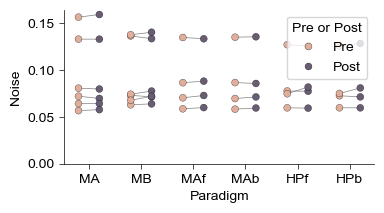

Emergence MA: TtestResult(statistic=1.4019115323476738, pvalue=0.21986644383251971, df=5)
Emergence MB: TtestResult(statistic=1.1091416143415112, pvalue=0.3178457785780319, df=5)
Emergence MAf: TtestResult(statistic=-2.8485200671168123, pvalue=0.06518823825148132, df=3)
Emergence MAb: TtestResult(statistic=-1.5850239482342647, pvalue=0.21113762781915205, df=3)
Emergence HPf: TtestResult(statistic=-0.6583602920380925, pvalue=0.5573211566910746, df=3)
Emergence HPb: TtestResult(statistic=-0.5288258031794106, pvalue=0.6335543324134961, df=3)


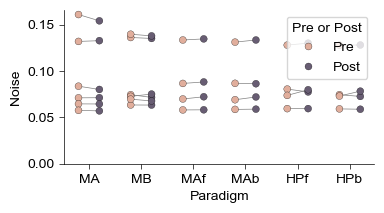

In [9]:
with open(join(figdata, f"{code_id} [Session-Average].pkl"), 'rb') as f:
    AvgChange = pickle.load(f)

for event in event_set:
    SubData = SubDict(AvgChange, AvgChange.keys(), np.where(AvgChange['Event'] == event)[0])
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.stripplot(
        x='Paradigm',
        y='Noise',
        hue='Pre or Post',
        data=SubData,
        order=paradm_set,
        palette=['#E1AE9C', '#685d73'],
        dodge=True,
        edgecolor='k',
        linewidth=0.2,
        jitter=0,
        size=5,
        ax=ax,
        zorder=1,
    )
    for i, paradm in enumerate(paradm_set):
        idx_pre = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Pre')
        )[0]
        idx_post = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Post')
        )[0]
        print(f"{event} {paradm}: {ttest_rel(SubData['Noise'][idx_pre], SubData['Noise'][idx_post])}")
        for j in range(idx_pre.shape[0]):
            ax.plot(
                [i-0.2, i+0.2],
                [SubData['Noise'][idx_pre[j]], SubData['Noise'][idx_post[j]]],
                color='gray',
                linewidth=0.5,
                zorder=0,
            )
    ax.set_ylim(0, ax.get_ylim()[1])
    plt.savefig(join(loc, f"Noise Change [{event}].png"), dpi=600)
    plt.savefig(join(loc, f"Noise Change [{event}].svg"))
    plt.show()

        

# SNR

Retention MA: TtestResult(statistic=1.873827010560762, pvalue=0.11982297198455644, df=5)
Retention MB: TtestResult(statistic=7.833142745660635, pvalue=0.0005440367121274555, df=5)
Retention MAf: TtestResult(statistic=1.2279429467511633, pvalue=0.30702497242425963, df=3)
Retention MAb: TtestResult(statistic=1.3798929632113954, pvalue=0.2614763616974931, df=3)
Retention HPf: TtestResult(statistic=4.265301534495603, pvalue=0.023644328427690563, df=3)
Retention HPb: TtestResult(statistic=3.0090280045296214, pvalue=0.05725596808696402, df=3)


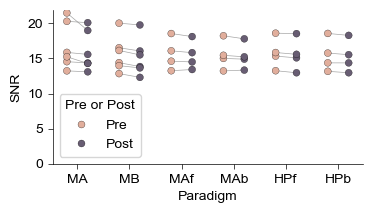

Disappearance MA: TtestResult(statistic=-0.3383599836217759, pvalue=0.7488373211551107, df=5)
Disappearance MB: TtestResult(statistic=-1.0916820524875919, pvalue=0.32476162400148434, df=5)
Disappearance MAf: TtestResult(statistic=-5.756305209348232, pvalue=0.010417368137814112, df=3)
Disappearance MAb: TtestResult(statistic=-7.205312337082474, pvalue=0.005510466225470191, df=3)
Disappearance HPf: TtestResult(statistic=-5.393728667097839, pvalue=0.012488561445943454, df=3)
Disappearance HPb: TtestResult(statistic=-4.147424852970359, pvalue=0.025466348267405077, df=3)


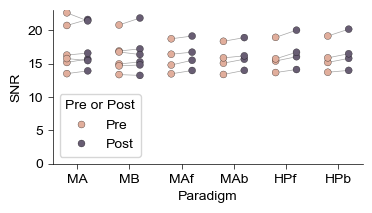

Emergence MA: TtestResult(statistic=2.6316091388012923, pvalue=0.046443124123642196, df=5)
Emergence MB: TtestResult(statistic=13.033204849459763, pvalue=4.742828022140632e-05, df=5)
Emergence MAf: TtestResult(statistic=3.5105222432265295, pvalue=0.03918314069545187, df=3)
Emergence MAb: TtestResult(statistic=3.7911509143353577, pvalue=0.03219781886933508, df=3)
Emergence HPf: TtestResult(statistic=6.247792658570305, pvalue=0.008272196304856195, df=3)
Emergence HPb: TtestResult(statistic=4.538153160266576, pvalue=0.02003027060573059, df=3)


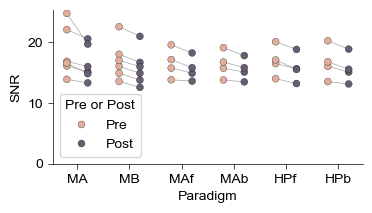

In [11]:
with open(join(figdata, f"{code_id} [Session-Average].pkl"), 'rb') as f:
    AvgChange = pickle.load(f)

for event in event_set:
    SubData = SubDict(AvgChange, AvgChange.keys(), np.where(AvgChange['Event'] == event)[0])
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.stripplot(
        x='Paradigm',
        y='SNR',
        hue='Pre or Post',
        data=SubData,
        order=paradm_set,
        palette=['#E1AE9C', '#685d73'],
        dodge=True,
        edgecolor='k',
        linewidth=0.2,
        jitter=0,
        size=5,
        ax=ax,
        zorder=1,
    )
    for i, paradm in enumerate(paradm_set):
        idx_pre = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Pre')
        )[0]
        idx_post = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Post')
        )[0]
        print(f"{event} {paradm}: {ttest_rel(SubData['SNR'][idx_pre], SubData['SNR'][idx_post])}")
        for j in range(idx_pre.shape[0]):
            ax.plot(
                [i-0.2, i+0.2],
                [SubData['SNR'][idx_pre[j]], SubData['SNR'][idx_post[j]]],
                color='gray',
                linewidth=0.5,
                zorder=0,
                alpha=0.7
            )
            
    ax.set_ylim(0, ax.get_ylim()[1])
    plt.savefig(join(loc, f"SNR Change [{event}].png"), dpi=600)
    plt.savefig(join(loc, f"SNR Change [{event}].svg"))
    plt.show()

# Rate Change

Retention MA: TtestResult(statistic=-2.8631962134760878, pvalue=0.035274254405810584, df=5)
Retention MB: TtestResult(statistic=-3.3668461801336105, pvalue=0.01995823469827693, df=5)
Retention MAf: TtestResult(statistic=-0.97233565577363, pvalue=0.40260027508271995, df=3)
Retention MAb: TtestResult(statistic=-2.442110835187208, pvalue=0.09232623842826887, df=3)
Retention HPf: TtestResult(statistic=-2.499803302998106, pvalue=0.08772185782194053, df=3)
Retention HPb: TtestResult(statistic=-4.2619962095112305, pvalue=0.02369308213605216, df=3)


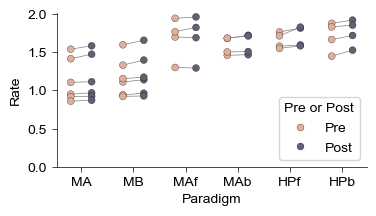

Disappearance MA: TtestResult(statistic=11.015688545090514, pvalue=0.00010731095943479729, df=5)
Disappearance MB: TtestResult(statistic=12.516896405777983, pvalue=5.775241968565227e-05, df=5)
Disappearance MAf: TtestResult(statistic=13.76827121310918, pvalue=0.0008291742577446616, df=3)
Disappearance MAb: TtestResult(statistic=14.938746215052703, pvalue=0.000650978283562953, df=3)
Disappearance HPf: TtestResult(statistic=22.1949956897731, pvalue=0.00020023539458134025, df=3)
Disappearance HPb: TtestResult(statistic=13.925526033798839, pvalue=0.0008017366713766531, df=3)


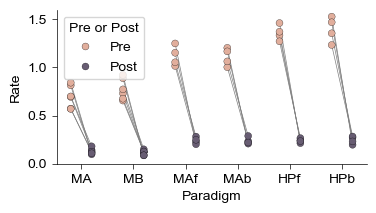

Emergence MA: TtestResult(statistic=-9.758467305217456, pvalue=0.00019219103388314025, df=5)
Emergence MB: TtestResult(statistic=-11.424178718010223, pvalue=8.998515315315101e-05, df=5)
Emergence MAf: TtestResult(statistic=-13.790941342030276, pvalue=0.0008251426007228493, df=3)
Emergence MAb: TtestResult(statistic=-13.975865075177929, pvalue=0.0007932089828674348, df=3)
Emergence HPf: TtestResult(statistic=-16.339934420762926, pvalue=0.0004987636720656139, df=3)
Emergence HPb: TtestResult(statistic=-12.79363624541689, pvalue=0.001030429352591778, df=3)


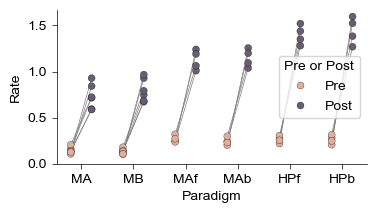

In [7]:
with open(join(figdata, f"{code_id} [Session-Average].pkl"), 'rb') as f:
    AvgChange = pickle.load(f)
    
for event in event_set:
    SubData = SubDict(AvgChange, AvgChange.keys(), np.where(AvgChange['Event'] == event)[0])
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.stripplot(
        x='Paradigm',
        y='Rate',
        hue='Pre or Post',
        data=SubData,
        order=paradm_set,
        palette=['#E1AE9C', '#685d73'],
        dodge=True,
        edgecolor='k',
        linewidth=0.2,
        jitter=0,
        size=5,
        ax=ax,
        zorder=1,
    )
    for i, paradm in enumerate(paradm_set):
        idx_pre = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Pre')
        )[0]
        idx_post = np.where(
            (SubData['Paradigm'] == paradm) &
            (SubData['Pre or Post'] == 'Post')
        )[0]
        print(f"{event} {paradm}: {ttest_rel(SubData['Rate'][idx_pre], SubData['Rate'][idx_post])}")
        for j in range(idx_pre.shape[0]):
            ax.plot(
                [i-0.2, i+0.2],
                [SubData['Rate'][idx_pre[j]], SubData['Rate'][idx_post[j]]],
                color='gray',
                linewidth=0.5,
                zorder=0
            )
    ax.set_ylim(0, ax.get_ylim()[1])
    plt.savefig(join(loc, f"Rate Change [{event}].png"), dpi=600)
    plt.savefig(join(loc, f"Rate Change [{event}].svg"))
    plt.show()

# Get Peak Rate Distribution for Different Type of Evolutionary Event

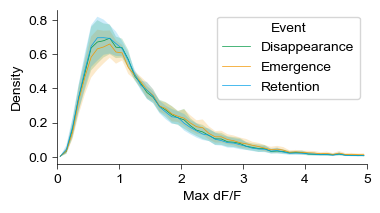

In [26]:
def get_distribution_of_dFF(
    i: int,
    f: pd.DataFrame = f_CellReg_modi,
    dirs: str = 'cis',
):

    with open(f['Trace File'][i], 'rb') as handle:
        trace_mdays = pickle.load(handle)
        
    try:
        field_reg = trace_mdays['field_reg']
        field_info = trace_mdays['field_info']
        field_info_adv = trace_mdays['field_info_adv']
    except:
        field_info_adv = trace_mdays[dirs]['field_info_adv']
        field_reg = trace_mdays[dirs]['field_reg']
        field_info = trace_mdays[dirs]['field_info']
    
    # field to cell mapping
    ftc_mapping = field_info[:, :, 0]

    res = {
        "Session": [],
        "Event": [],
        "Max dF/F": [],
        "Noise": [],
        "SNR": [],
        "Rate": [],
        "Pre or Post": [],
    }

    for s in tqdm(range(field_reg.shape[0]-1)):
        field_idx = np.where(
            (ftc_mapping[s, :] > 0) &
            (ftc_mapping[s+1, :] > 0)
        )[0]
        ftc_s = ftc_mapping[:, field_idx][s:s+2, :].astype(np.int64)
        reg_s = field_reg[:, field_idx][s:s+2, :].astype(np.int64)
        # Field Retention
        ret_idx = np.where(
            (reg_s[0, :] == 1) &
            (reg_s[1, :] == 1)
        )[0]
        max_dFF_changes = field_info_adv[s:s+2, field_idx[ret_idx], 0]
        noises = field_info_adv[s:s+2, field_idx[ret_idx], 1]
        snr = field_info_adv[s:s+2, field_idx[ret_idx], 2]
        rates = field_info_adv[s:s+2, field_idx[ret_idx], 3]

        res['Session'].append(np.repeat(s, 2*ret_idx.shape[0]))
        res['Event'].append(np.repeat('Retention', 2*ret_idx.shape[0]))
        res['Max dF/F'].append(np.concatenate([max_dFF_changes[0, :], max_dFF_changes[1, :]]))
        res['Noise'].append(np.concatenate([noises[0, :], noises[1, :]]))
        res['SNR'].append(np.concatenate([snr[0, :], snr[1, :]]))
        res['Rate'].append(np.concatenate([rates[0, :], rates[1, :]]))
        res['Pre or Post'].append(np.array(['Pre']*ret_idx.shape[0] + ['Post']*ret_idx.shape[0]))
        
        # Field Disappearance
        dis_idx = np.where(
            (reg_s[0, :] == 1) &
            (reg_s[1, :] == 0)
        )[0]
        max_dFF_changes_ = field_info_adv[s:s+2, field_idx[dis_idx], 0]
        noises = field_info_adv[s:s+2, field_idx[dis_idx], 1]
        snr = field_info_adv[s:s+2, field_idx[dis_idx], 2]
        rates = field_info_adv[s:s+2, field_idx[dis_idx], 3]
        res['Session'].append(np.repeat(s, 2*dis_idx.shape[0]))
        res['Event'].append(np.repeat('Disappearance', 2*dis_idx.shape[0]))
        res['Max dF/F'].append(np.concatenate([max_dFF_changes_[0, :], max_dFF_changes_[1, :]]))
        res['Noise'].append(np.concatenate([noises[0, :], noises[1, :]]))
        res['SNR'].append(np.concatenate([snr[0, :], snr[1, :]]))
        res['Rate'].append(np.concatenate([rates[0, :], rates[1, :]]))
        res['Pre or Post'].append(np.array(['Pre']*dis_idx.shape[0] + ['Post']*dis_idx.shape[0]))
        
        # Field Emergence
        eme_idx = np.where(
            (reg_s[0, :] == 0) &
            (reg_s[1, :] == 1)
        )[0]
        max_dFF_changes_ = field_info_adv[s:s+2, field_idx[eme_idx], 0]
        noises = field_info_adv[s:s+2, field_idx[eme_idx], 1]
        snr = field_info_adv[s:s+2, field_idx[eme_idx], 2]
        rates = field_info_adv[s:s+2, field_idx[eme_idx], 3]
        res['Session'].append(np.repeat(s, 2*eme_idx.shape[0]))
        res['Event'].append(np.repeat('Emergence', 2*eme_idx.shape[0]))
        res['Max dF/F'].append(np.concatenate([max_dFF_changes_[0, :], max_dFF_changes_[1, :]]))
        res['Noise'].append(np.concatenate([noises[0, :], noises[1, :]]))
        res['SNR'].append(np.concatenate([snr[0, :], snr[1, :]]))
        res['Rate'].append(np.concatenate([rates[0, :], rates[1, :]]))
        res['Pre or Post'].append(np.array(['Pre']*eme_idx.shape[0] + ['Post']*eme_idx.shape[0]))
    for k in res.keys():
        res[k] = np.concatenate(res[k]) 
        
    return res

if exists(join(figdata, f"{code_id} [Peak dFF Distribution].pkl")) == False:
    DistriPeakdFF = {
        "MiceID": [], 
        "Paradigm": [],
        "Event": [],
        "Max dF/F": [],
        "Density": []
    }
    _range = (0, 5)
    nbins = 50
    
    for i in range(f_CellReg_modi.shape[0]):
        if f_CellReg_modi['Type'][i] != 'Real':
            continue
        
        mouse = int(f_CellReg_modi['MiceID'][i])
        print(f"Mouse {mouse} ",end='')
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            paradm = "MA" if f_CellReg_modi['maze_type'][i] == 1 else "MB"
            print(paradm)
            res = get_distribution_of_dFF(i)
            
            for event in ['Disappearance', 'Emergence', 'Retention']:
                hist_pre, x_pre = np.histogram(
                    res['Max dF/F'][(res['Pre or Post'] == 'Pre') & (res['Event'] == event)],
                    bins=nbins, 
                    range=_range, 
                    density=True
                )
                x_pre = (x_pre[1:]+x_pre[:-1])/2

                DistriPeakdFF['MiceID'].append(np.repeat(mouse, x_pre.shape[0]))
                DistriPeakdFF['Paradigm'].append(np.repeat(paradm, x_pre.shape[0]))
                DistriPeakdFF['Event'].append(np.repeat(event, x_pre.shape[0]))
                DistriPeakdFF['Max dF/F'].append(x_pre)
                DistriPeakdFF['Density'].append(hist_pre)

        elif f_CellReg_modi['paradigm'][i] == 'ReverseMaze':
            for dirs, paradm in zip(['cis', 'trs'], ['MAf', 'MAb']):
                print(paradm)
                res = get_distribution_of_dFF(i, dirs=dirs)
                
                for event in ['Disappearance', 'Emergence', 'Retention']:
                    hist_pre, x_pre = np.histogram(
                        res['Max dF/F'][(res['Pre or Post'] == 'Pre') & (res['Event'] == event)],
                        bins=nbins, 
                        range=_range, 
                        density=True
                    )
                    x_pre = (x_pre[1:]+x_pre[:-1])/2

                    DistriPeakdFF['MiceID'].append(np.repeat(mouse, x_pre.shape[0]))
                    DistriPeakdFF['Paradigm'].append(np.repeat(paradm, x_pre.shape[0]))
                    DistriPeakdFF['Event'].append(np.repeat(event, x_pre.shape[0]))
                    DistriPeakdFF['Max dF/F'].append(x_pre)
                    DistriPeakdFF['Density'].append(hist_pre)
                    
        elif f_CellReg_modi['paradigm'][i] == 'HairpinMaze':
            for dirs, paradm in zip(['cis', 'trs'], ['HPf', 'HPb']):
                print(paradm)
                res = get_distribution_of_dFF(i, dirs=dirs)
                for event in ['Disappearance', 'Emergence', 'Retention']:
                    hist_pre, x_pre = np.histogram(
                        res['Max dF/F'][(res['Pre or Post'] == 'Pre') & (res['Event'] == event)],
                        bins=nbins, 
                        range=_range, 
                        density=True
                    )
                    x_pre = (x_pre[1:]+x_pre[:-1])/2

                    DistriPeakdFF['MiceID'].append(np.repeat(mouse, x_pre.shape[0]))
                    DistriPeakdFF['Paradigm'].append(np.repeat(paradm, x_pre.shape[0]))
                    DistriPeakdFF['Event'].append(np.repeat(event, x_pre.shape[0]))
                    DistriPeakdFF['Max dF/F'].append(x_pre)
                    DistriPeakdFF['Density'].append(hist_pre)
                    
    for k in DistriPeakdFF.keys():
        DistriPeakdFF[k] = np.concatenate(DistriPeakdFF[k])
        
    DistriPeakdFFD = pd.DataFrame(DistriPeakdFF)
    with open(join(figdata, f"{code_id} [Peak dFF Distribution].pkl"), 'wb') as handle:
        pickle.dump(DistriPeakdFF, handle)
        
    DistriPeakdFFD.to_excel(join(figdata, f"{code_id} [Peak dFF Distribution].xlsx"), index=False)
    print(len(DistriPeakdFFD))
else:
    with open(join(figdata, f"{code_id} [Peak dFF Distribution].pkl"), 'rb') as handle:
        DistriPeakdFF = pickle.load(handle) 
        
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Max dF/F',
    y='Density',
    hue='Event',
    data=DistriPeakdFF,
    palette=['#009844', '#f29600', '#009fe8'],
    ax=ax,
    err_kws={'edgecolor': None},
    linewidth=0.5,
)
ax.set_xlim(0, 5)
ax.set_xticks(np.linspace(0, 5, 6))
plt.savefig(join(loc, f"Peak dF-F Distribution [All].png"), dpi=600)
plt.savefig(join(loc, f"Peak dF-F Distribution [All].svg"), dpi=600)
plt.show()